In [42]:
from utils.data_generated import *
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Clusters names

To decide on the clusters names, we looked at the results of the ethnicites graphs, we then linked those results to known names of movie industry.

In [43]:
RESULTS_PATH = '../results/clusters/'
CLUSTER1_NAME = 'Hollywood'
CLUSTER2_NAME = 'Bollywood (North)'
CLUSTER3_NAME = 'Asian Cinema'
CLUSTER4_NAME = 'Korean Cinema'
CLUSTER5_NAME = 'Bollywood (South)'
CLUSTERNAME_MAP = {1: CLUSTER1_NAME, 2: CLUSTER2_NAME, 3: CLUSTER3_NAME, 4: CLUSTER4_NAME, 5: CLUSTER5_NAME}

In [44]:
#In order to have always same colors for the same cluster
colors = sns.color_palette("viridis", 5)
PALETTE = {CLUSTER3_NAME: colors[0], CLUSTER2_NAME: colors[1], CLUSTER5_NAME: colors[2], CLUSTER1_NAME: colors[3], CLUSTER4_NAME: colors[4]}

In [45]:
#load panda dataframes for movies, poeple, clusters, and ethincities
movies = load_movie_metadata()
people = load_people()
cluster = load_cluster_optics()
ethnicities = load_ethnicities()

In [46]:
#transfomr dict cluster into dataframe, index is the cluster key and the corresponding value is the cluster value, with columns names person_name_id and cluster_id
cluster_df = pd.DataFrame.from_dict(cluster, orient='index', columns=['cluster_id'])
#name the index column
cluster_df.index.name = 'person_name_id'

#print number of clusters
print("Number of clusters: ", len(cluster_df.cluster_id.unique()))

Number of clusters:  6


There are a total of 6 clusters, 1 is the clusters of the outliers (with value -1).

In [47]:
#create panda dataframe on all custer_id == i, take corresponding person from people matching on person_name_id 
cluster1 = cluster_df[cluster_df['cluster_id'] == 0].join(people.set_index('person_name_id'))
cluster2 = cluster_df[cluster_df['cluster_id'] == 1].join(people.set_index('person_name_id'))
cluster3 = cluster_df[cluster_df['cluster_id'] == 2].join(people.set_index('person_name_id'))
cluster4 = cluster_df[cluster_df['cluster_id'] == 3].join(people.set_index('person_name_id'))
cluster5 = cluster_df[cluster_df['cluster_id'] == 4].join(people.set_index('person_name_id'))
cluster_outlier = cluster_df[cluster_df['cluster_id'] == -1].join(people.set_index('person_name_id'))


In [48]:
#print the number of people in each cluster
print('number of people in cluster 1: ', len(cluster1))
print('number of people in cluster 2: ', len(cluster2))
print('number of people in cluster 3: ', len(cluster3))
print('number of people in cluster 4: ', len(cluster4))
print('number of people in cluster 5: ', len(cluster5))
print('number of people in cluster outlier: ', len(cluster_outlier))

number of people in cluster 1:  25417
number of people in cluster 2:  2324
number of people in cluster 3:  1219
number of people in cluster 4:  1140
number of people in cluster 5:  3341
number of people in cluster outlier:  38299


### Professions

For each clusters, we looked at the distribution of the professions. We ploted the result on a single graph, in order to highlight potential differences among clusters. We see for example that Hollywood as more producer than actors or writers, while the other clusters tend to have more actors than producers. Also, in the korean cinema, we see a high number of actresses compared to the other clusters. However, this could be induced by the missing values we have in the dataset.

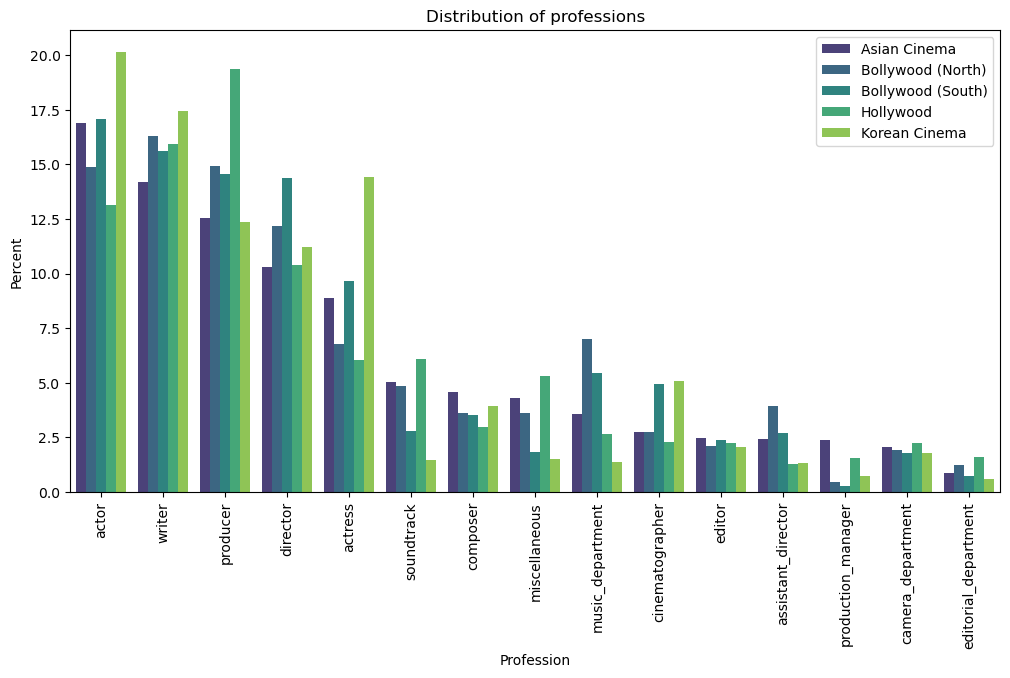

In [49]:
cluster1_jobs = pd.DataFrame([j for l in cluster1.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_jobs = pd.DataFrame([j for l in cluster2.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_jobs = pd.DataFrame([j for l in cluster3.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_jobs = pd.DataFrame([j for l in cluster4.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_jobs = pd.DataFrame([j for l in cluster5.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

cluster1_jobs['Cluster'] = CLUSTER1_NAME
cluster2_jobs['Cluster'] = CLUSTER2_NAME
cluster3_jobs['Cluster'] = CLUSTER3_NAME
cluster4_jobs['Cluster'] = CLUSTER4_NAME
cluster5_jobs['Cluster'] = CLUSTER5_NAME

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_jobs, cluster2_jobs, cluster3_jobs, cluster4_jobs, cluster5_jobs]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['Profession']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['Profession'].isin(agg.index)]
#sort data by cluster
data.sort_values(by=['Cluster', 'Percent'], ascending=[True, False], inplace=True)
sns.barplot(data=data, x='Profession', y='Percent', hue='Cluster', palette=PALETTE)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of professions")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'clusters_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

Check for misclassification of actress and actor to gender M and F

In [50]:
#get entries in people taht have entry F for 'gender' and actor for 'primary_profession'
f = people[['gender', 'primary_profession']].dropna()
#drop all entries that are not actress
f = f[['actress' in x for x in f['primary_profession']]]
f = f[f['gender'] == 'M']
len(f)

34

In [51]:
#get entries in people that have entry F for 'gender' and actor for 'primary_profession'
m = people[['gender', 'primary_profession']].dropna()
#drop all entries that are not actress
m = m[['actor' in x for x in m['primary_profession']]]
m = m[m['gender'] == 'F']
len(m)

44

### Movie genres

In [52]:
#get all titles of movies in cluster 1 from columns known_for_titles. each entry is a list of titles. save all titles in a list, removing duplicates
def get_titles(cluster):
    titles_cluster = set()
    for i in range(len(cluster)):
        if type(cluster.iloc[i].known_for_titles) == list:
            for title in cluster.iloc[i].known_for_titles:
                titles_cluster.add(title)

    #make it a dataframe
    return pd.DataFrame(list(titles_cluster), columns=['title'])


In [53]:
titles_cluster1 = get_titles(cluster1)
titles_cluster2 = get_titles(cluster2)
titles_cluster3 = get_titles(cluster3)
titles_cluster4 = get_titles(cluster4)
titles_cluster5 = get_titles(cluster5)

In [54]:
#keep only movies that are in the cluster 1
movies_cluster1 = movies[movies['title_id_imdb'].isin(titles_cluster1['title'])]
movies_cluster2 = movies_cluster1[movies_cluster1['title_id_imdb'].isin(titles_cluster2['title'])]
movies_cluster3 = movies_cluster1[movies_cluster1['title_id_imdb'].isin(titles_cluster3['title'])]
movies_cluster4 = movies_cluster1[movies_cluster1['title_id_imdb'].isin(titles_cluster4['title'])]
movies_cluster5 = movies_cluster1[movies_cluster1['title_id_imdb'].isin(titles_cluster5['title'])]


Plot IMDb and CMU genres separately because they yield different conclusions.

CMU genres are more specific but less consistent due to the crowdsourcing nature of data.

IMDb genres are less (19 of them) but more consistent.

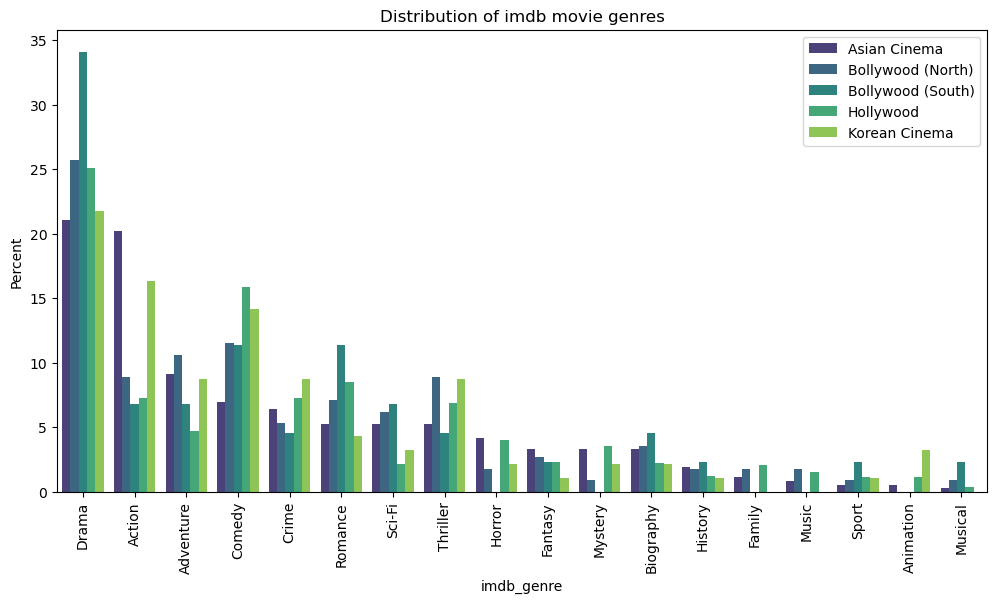

In [55]:
cluster1_imdb_genres = pd.DataFrame([j for l in movies_cluster1.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_imdb_genres = pd.DataFrame([j for l in movies_cluster2.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_imdb_genres = pd.DataFrame([j for l in movies_cluster3.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_imdb_genres = pd.DataFrame([j for l in movies_cluster4.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_imdb_genres = pd.DataFrame([j for l in movies_cluster5.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

cluster1_imdb_genres['Cluster'] = CLUSTER1_NAME
cluster2_imdb_genres['Cluster'] = CLUSTER2_NAME
cluster3_imdb_genres['Cluster'] = CLUSTER3_NAME
cluster4_imdb_genres['Cluster'] = CLUSTER4_NAME
cluster5_imdb_genres['Cluster'] = CLUSTER5_NAME

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_imdb_genres, cluster2_imdb_genres, cluster3_imdb_genres, cluster4_imdb_genres, cluster5_imdb_genres]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['imdb_genre']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['imdb_genre'].isin(agg.index)]
data.sort_values(by=['Cluster', 'Percent'], ascending=[True, False], inplace=True)
sns.barplot(data=data, x='imdb_genre', y='Percent', hue='Cluster', palette=PALETTE)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of imdb movie genres")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'clusters_distribution_imdb_genres.png', bbox_inches='tight', dpi=500)

plt.show()

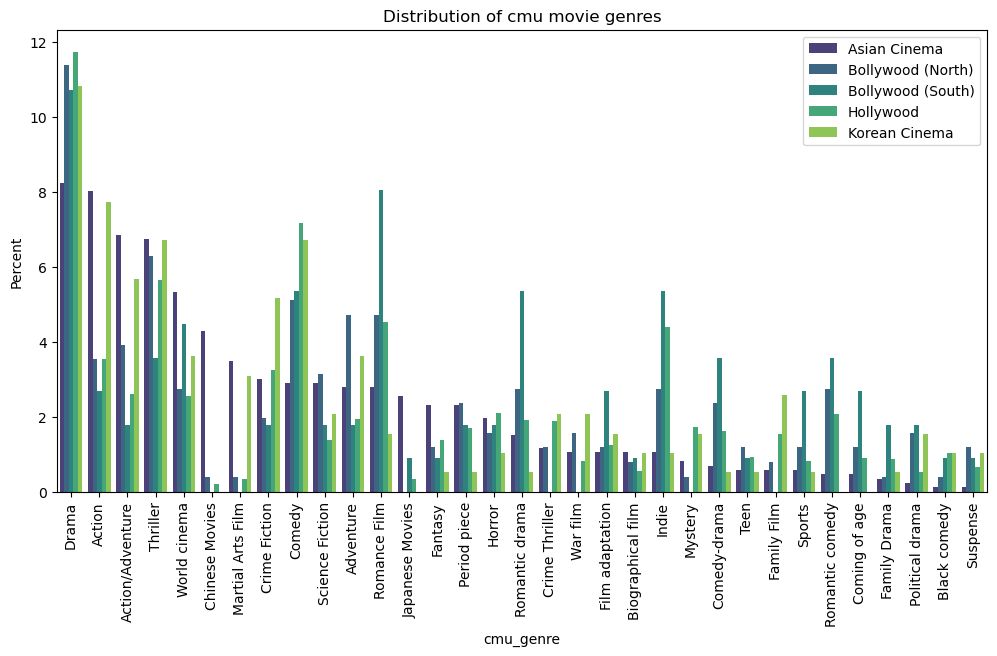

In [56]:
cluster1_imdb_genres = pd.DataFrame([j for l in movies_cluster1.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_imdb_genres = pd.DataFrame([j for l in movies_cluster2.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_imdb_genres = pd.DataFrame([j for l in movies_cluster3.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_imdb_genres = pd.DataFrame([j for l in movies_cluster4.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_imdb_genres = pd.DataFrame([j for l in movies_cluster5.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

cluster1_imdb_genres['Cluster'] = CLUSTER1_NAME
cluster2_imdb_genres['Cluster'] = CLUSTER2_NAME
cluster3_imdb_genres['Cluster'] = CLUSTER3_NAME
cluster4_imdb_genres['Cluster'] = CLUSTER4_NAME
cluster5_imdb_genres['Cluster'] = CLUSTER5_NAME

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_imdb_genres, cluster2_imdb_genres, cluster3_imdb_genres, cluster4_imdb_genres, cluster5_imdb_genres]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['cmu_genre']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['cmu_genre'].isin(agg.index)]
data.sort_values(by=['Cluster', 'Percent'], ascending=[True, False], inplace=True)
sns.barplot(data=data, x='cmu_genre', y='Percent', hue='Cluster', palette=PALETTE)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of cmu movie genres")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'clusters_distribution_cmu_genres.png', bbox_inches='tight', dpi=500)

plt.show()

### Ethnicity

In [57]:
#add column to ethnicites with name occurences
def get_ethnicities(cluster):
	e = ethnicities.copy()
	e['occurences'] = 0
	for ethnicity in people['ethnicity'].unique():
		#count occurence of ethnicit in cluster1
		count = len(cluster[cluster['ethnicity'] == ethnicity])
		e.loc[e['freebase_id'] == ethnicity, 'occurences'] = count
	e.drop(['freebase_id'], axis=1, inplace=True)
	e.dropna(inplace=True)
	e.drop(e[e['occurences'] == 0].index, inplace=True)
	e.sort_values(by=['occurences'], ascending=False, inplace=True)
	return e


In [58]:
ethnicities1 = get_ethnicities(cluster1)
ethnicities2 = get_ethnicities(cluster2)
ethnicities3 = get_ethnicities(cluster3)
ethnicities4 = get_ethnicities(cluster4)
ethnicities5 = get_ethnicities(cluster5)	

In [59]:
ethnicities1

,ethnicity,occurences
0,African Americans,338
2,Jewish people,263
20,English people,215
3,Irish Americans,97
15,Italian Americans,79
...,...,...
213,Ojibwe,1
80,Rusyn American,1
203,Czechs,1
199,Sámi people,1


In [60]:
#plot ethnicities 1 ditribution
def plot_eth(*args, n):
    fig, axes = plt.subplots(1, 5)
    fig.set_size_inches(20, 5)
    fig.suptitle('{} most represented ethnicities in each cluster'.format(n))

    for i, (eth, id) in enumerate(args):
        eth = eth.copy()
        eth = eth[eth['occurences'] > 0]

        #normalize
        eth.occurences = (eth.occurences/eth.occurences.agg('sum'))*100

        num = eth.shape[0]
        if num > n:
            num = n
        eth = eth[:num]
        
        sns.barplot(data=eth, x='ethnicity', y='occurences', ax=axes[i], palette='rocket')
        
        axes[i].set_title(CLUSTERNAME_MAP[i+1])
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        axes[i].set_xticklabels(eth.ethnicity.values, rotation=90)
    
    axes[2].set_xlabel('Ethnicity')
    axes[0].set_ylabel('Percent')

    plt.savefig(RESULTS_PATH + 'clusters_ethnicities.png', bbox_inches='tight', dpi=500)

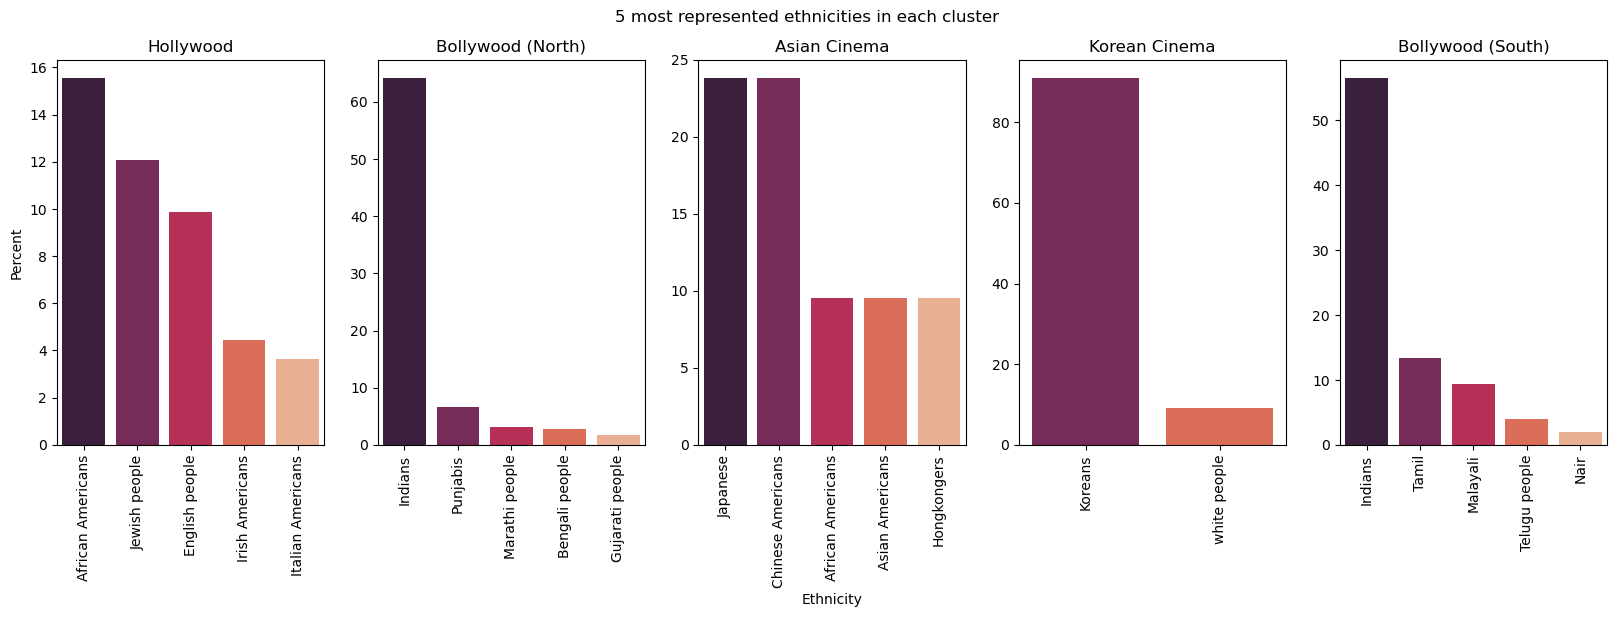

In [61]:
plot_eth((ethnicities1, 1), (ethnicities2, 2),
         (ethnicities3, 3), (ethnicities4, 4),(ethnicities5, 5), n=5)

### Connections

In [62]:
graph = load_graph()

In [63]:
def get_con(cluster):
    cluster_co = {n: graph.nodes[n] for n in cluster.index}
    cluster_co = pd.DataFrame.from_dict(cluster_co, orient='index')
    cluster_co['cluster_id'] = cluster[cluster.index == cluster_co.index]['cluster_id']
    return cluster_co

In [64]:
def plot_connections(cluster):
    co = cluster.copy()
    co = co.sort_values(by='num_connections', ascending=True)
    #rename cluster_id to CLUSTERNAME_MAP
    co['cluster_id'] = (co['cluster_id']+1).map(CLUSTERNAME_MAP)
    co.sort_values(by='cluster_id', ascending=True, inplace=True)
    
    sns.ecdfplot(data=co, x='num_connections', palette=PALETTE, hue='cluster_id')

    plt.yscale('log')   
    plt.xscale('log')     

    plt.title('ECDF of Connectivity within clusters')
    plt.xlabel('Number of connections within cluster')
    plt.ylabel('Proportion')
    plt.legend(handles=handles[:], labels=labels[:])

    plt.savefig(RESULTS_PATH + 'clusters_connectivity.png', bbox_inches='tight', dpi=500)

    plt.show()
    

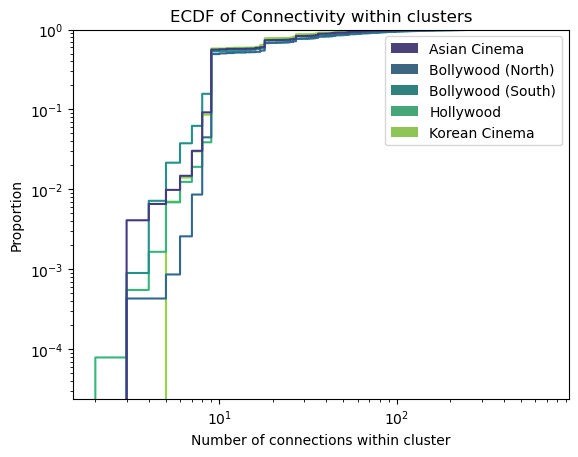

In [65]:
clusters_co = get_con(pd.concat([cluster1, cluster2, cluster3, cluster4, cluster5]))
plot_connections(clusters_co)

### Gender

In [66]:
percentage = (len(people) - len(people.gender.dropna()))/len(people)
print('There are {:.2%} of people with value for gender'.format(percentage))

There are 75.25% of people with value for gender


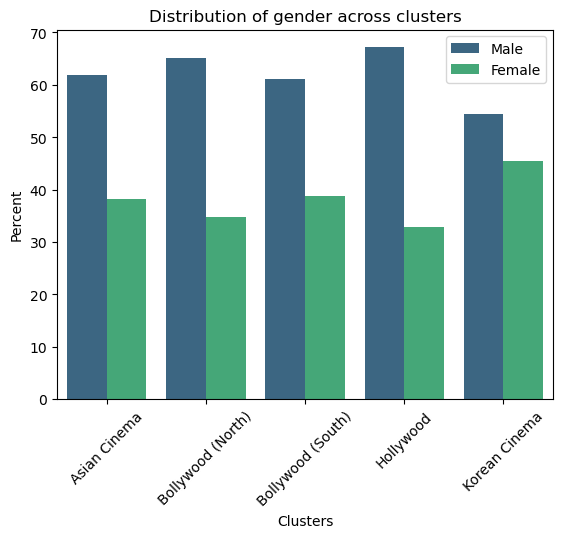

In [67]:
cluster1_gender = pd.DataFrame([j for l in cluster1.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_gender = pd.DataFrame([j for l in cluster2.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_gender = pd.DataFrame([j for l in cluster3.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_gender = pd.DataFrame([j for l in cluster4.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_gender = pd.DataFrame([j for l in cluster5.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()



cluster1_gender['Cluster'] = CLUSTER1_NAME
cluster2_gender['Cluster'] = CLUSTER2_NAME
cluster3_gender['Cluster'] = CLUSTER3_NAME
cluster4_gender['Cluster'] = CLUSTER4_NAME
cluster5_gender['Cluster'] = CLUSTER5_NAME


# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_gender, cluster2_gender, cluster3_gender, cluster4_gender, cluster5_gender]).sort_values(by='Percent', ascending=False)
#rename gender value to Male and Female in data dataframe 'gender'
data['gender'] = data['gender'].replace(['M'], 'Male')
data['gender'] = data['gender'].replace(['F'], 'Female')
data.sort_values(by=['Cluster'], ascending=True, inplace=True)
sns.barplot(data=data, x='Cluster', y='Percent', hue='gender', palette='viridis')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of gender across clusters")
plt.xlabel('Clusters')
plt.xticks(rotation=45)
plt.savefig(RESULTS_PATH + 'clusters_genders.png', bbox_inches='tight', dpi=500)

plt.show()




### Age distribution within clusters

In [68]:

def get_age_distribution(cluster, movies):
	'''for each person in cluster, for each title in known_for_titles, get the age of the person when the movie was released'''
	cluster_movies = pd.DataFrame()
	temp_m = pd.DataFrame()
	for person in cluster.index:
		p = cluster.loc[person]
		#drop if no known_for_titles
		titles = p['known_for_titles']
		#check if list contains float
		if isinstance(titles, float):
			continue
		for title in titles:
			# get movie relase_date where title_id_imdb == title
			release = movies[movies['title_id_imdb'] == title]['release_date']
			#check if series is empty
			if release.empty:
				continue
			# get age of person when movie was released
			#print(release.dt.year)
			#add to temp_m
			temp_m = pd.DataFrame({'age' : release.dt.year - p.birth_year, 'person' : p.person_name, 'title' : title})
			# append to cluster_movies
			cluster_movies = pd.concat([cluster_movies, temp_m])
		
	return cluster_movies

In [69]:
age1 = get_age_distribution(cluster1, movies_cluster1)
age2 = get_age_distribution(cluster2, movies_cluster2)
age3 = get_age_distribution(cluster3, movies_cluster3)
age4 = get_age_distribution(cluster4, movies_cluster4)
age5 = get_age_distribution(cluster5, movies_cluster5)

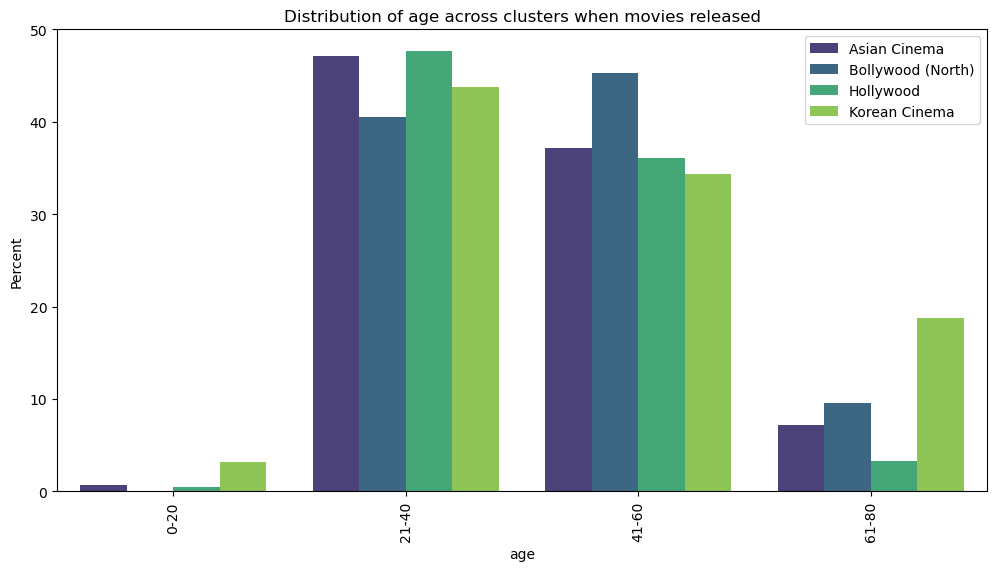

In [70]:
cluster1_age_d = pd.DataFrame([j for j in age1.age.dropna().values ], columns=['age']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_age_d = pd.DataFrame([j for j in age2.age.dropna().values ], columns=['age']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_age_d = pd.DataFrame([j for j in age3.age.dropna().values ], columns=['age']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_age_d = pd.DataFrame([j for j in age4.age.dropna().values ], columns=['age']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_age_d = pd.DataFrame([j for j in age5.age.dropna().values ], columns=['age']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

cluster1_age_d['Cluster'] = CLUSTER1_NAME
cluster2_age_d['Cluster'] = CLUSTER2_NAME
cluster3_age_d['Cluster'] = CLUSTER3_NAME
cluster4_age_d['Cluster'] = CLUSTER4_NAME
cluster5_age_d['Cluster'] = CLUSTER5_NAME

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_age_d, cluster2_age_d, cluster3_age_d, cluster4_age_d]).sort_values(by='Percent', ascending=True)
agg = data.groupby(['age']).sum().sort_values(by=['Percent'], ascending=True)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['age'].isin(agg.index)]
data.sort_values(by=['Cluster', 'Percent'], ascending=[True, True], inplace=True)

#aggreagte data such that there is 4 category of ages: 0-20, 21-40, 41-60, 61-80 , add percentage of each category to each cluster
data['age'] = pd.cut(data['age'], bins=[0, 20, 40, 60, 80], labels=['0-20', '21-40', '41-60', '61-80'])
data = data.groupby(['age', 'Cluster']).sum().reset_index()
sns.barplot(data=data, x='age', y='Percent', hue='Cluster', palette=PALETTE)
#make line plot
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)



plt.title("Distribution of age across clusters when movies released")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'clusters_distribution_age.png', bbox_inches='tight', dpi=500)

plt.show()